# Keyness analysis

In [2]:
# This reload library is just used for developing the REPUBLIC hOCR parser 
# and can be removed once this module is stable.
%reload_ext autoreload
%autoreload 2

In [29]:
import ast
import sys

import numpy as np
import pandas as pd
import seaborn as sns
from top2vec import Top2Vec
from scipy.spatial.distance import cosine 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm

from src.topic_summary import ModelAnalyser, NurGenreMapper, ReviewExtractor

#### Set paths and load functions

In [4]:
# please adjust the following paths to reflect the location of the following files in your local directory

impact_file = '../data/review-impact_matches.tsv.gz'
raw_review_data = '../data/reviews-stats.tsv.gz'
isbn_map = "../data/work-isbn-mapping.tsv"
isbn_work_id_mappings_file = "../data/work_isbn_title_genre.tsv.gz"
isbn_topic_file = '../data/isbn_topic_scores.tsv.gz'

In [33]:
isbn_topic = pd.read_csv(isbn_topic_file, sep='\t', compression='gzip', dtype={'isbn': str})
isbn_topic['themes'] = isbn_topic.themes.apply(ast.literal_eval)
isbn_topic

,isbn,topic,score,themes
0,9789045020860,50,0.259000,[Arts]
1,9789403127705,20,0.358931,"[Behaviours / feelings, Medicine / health]"
2,9789025440879,85,0.262251,[Geography and setting]
3,9789026152412,85,0.257781,[Geography and setting]
4,9789021572246,50,0.286553,[Arts]
...,...,...,...,...
18462,9789029731027,85,0.250844,[Geography and setting]
18463,9789021560229,20,0.285592,"[Behaviours / feelings, Medicine / health]"
18464,9789020411324,18,0.280647,"[Behaviours / feelings, School]"
18465,9789460415210,18,0.262735,"[Behaviours / feelings, School]"


In [52]:
isbn_theme = isbn_topic.explode('themes')[['isbn', 'themes']].set_index('isbn')
isbn_theme = pd.get_dummies(isbn_theme).reset_index().groupby('isbn').sum().reset_index()
isbn_theme

,isbn,themes_Arts,themes_Behaviours / feelings,themes_Crime,themes_Culture,themes_Geography and setting,themes_History,themes_Law,themes_Lifestyle and sport,themes_Medicine / health,themes_Other,themes_Politics,"themes_Religion, spirituality and philosophy",themes_Romance and sex,themes_School,"themes_Supernatural, fantasy and sci-fi",themes_War,themes_Wildlife / nature
0,9789020200485,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,9789020201451,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,9789020202106,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,9789020205008,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,9789020205268,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18462,9789493189560,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
18463,9789493189584,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18464,9789493189607,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
18465,9789493189669,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [50]:
# read work genre mapping
work_genre = read_genre_file(isbn_work_id_mappings_file)
work_genre = work_genre[work_genre.record_id_type == 'isbn'].rename(columns={'record_id': 'isbn'})
work_genre = work_genre[['work_id', 'isbn', 'nur_genre']]
work_genre.shape

(189038, 3)

In [77]:
work_genre_theme = pd.merge(work_genre, isbn_theme, on='isbn').drop('isbn', axis=1)
work_genre_theme.head(5)

,work_id,nur_genre,themes_Arts,themes_Behaviours / feelings,themes_Crime,themes_Culture,themes_Geography and setting,themes_History,themes_Law,themes_Lifestyle and sport,themes_Medicine / health,themes_Other,themes_Politics,"themes_Religion, spirituality and philosophy",themes_Romance and sex,themes_School,"themes_Supernatural, fantasy and sci-fi",themes_War,themes_Wildlife / nature
0,impfic-work-6,Suspense,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,impfic-work-10,Non-fiction,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,impfic-work-19,Other fiction,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,impfic-work-23,Literary_fiction,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,impfic-work-24,Historical_fiction,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0


In [225]:
print(work_genre_theme.shape)
work_genre_theme.nur_genre.value_counts() / len(work_genre_theme)

(18465, 19)


Literary_fiction      0.298890
Non-fiction           0.284538
Other fiction         0.108042
Suspense              0.092066
Regional_fiction      0.047983
Literary_thriller     0.044571
Children_fiction      0.030219
Romanticism           0.028703
Young_adult           0.026807
Fantasy_fiction       0.019767
Historical_fiction    0.018413
Name: nur_genre, dtype: float64

In [7]:
from impfic_core.map.map_genre import read_genre_file

# read review metadata
review_stats = pd.read_csv(raw_review_data, sep='\t', compression='gzip')

# merge review metadata and genre data
review_stats = pd.merge(review_stats, work_genre[['work_id', 'nur_genre']].drop_duplicates(), 
                        on='work_id', how='left')

# review professional reviews
review_stats = review_stats[review_stats.source != 'NBD_Biblion']


In [243]:
print('number of reviews:', len(review_stats))
review_stats.nur_genre.value_counts() / len(review_stats)

number of reviews: 634614


Literary_fiction      0.305584
Non-fiction           0.149828
Literary_thriller     0.119334
Suspense              0.104566
Other fiction         0.054745
Young_adult           0.045815
Children_fiction      0.039511
Fantasy_fiction       0.020644
Romanticism           0.009847
Historical_fiction    0.005184
Regional_fiction      0.002165
Name: nur_genre, dtype: float64

### Counting number of words per theme

- target: sum of number of words of reviews of works in theme
- ref: sum of number of words of reviews of works _not_ in theme

In [262]:
review_work_theme = pd.merge(review_stats, work_genre_theme, on='work_id', how='right')

print('number of reviews (with duplicates for works with multiple themes):', review_work_theme.shape)

review_work_theme.head(2)

number of reviews (with duplicates for works with multiple themes): (140511, 29)


,source,user_id,review_id,review_num_terms,review_num_words,num_sentences,review_date,review_text,rating,work_id,...,themes_Lifestyle and sport,themes_Medicine / health,themes_Other,themes_Politics,"themes_Religion, spirituality and philosophy",themes_Romance and sex,themes_School,"themes_Supernatural, fantasy and sci-fi",themes_War,themes_Wildlife / nature
0,Hebban,impfic-user-210605,impfic-review-42732,251.0,223.0,15.0,2016-11-12 14:56:29,'Orphan X' is het eerste deel in een serie thr...,4.0,impfic-work-6,...,0,0,0,0,0,0,0,0,1,0
1,Hebban,impfic-user-212219,impfic-review-42733,417.0,388.0,20.0,2018-01-27 11:00:26,Op de achterflap staat een verslag van het Min...,5.0,impfic-work-6,...,0,0,0,0,0,0,0,0,1,0


In [275]:
theme_cols = [col for col in review_work_theme.columns if col.startswith('themes_')]

theme_col = theme_cols[1]

targets = []
refs = []
for theme_col in theme_cols:
    target = review_work_theme[review_work_theme[theme_col] == 1].review_num_words.sum()
    ref = review_work_theme[review_work_theme[theme_col] == 0].review_num_words.sum()
    targets.append(target)
    refs.append(ref)

target = review_work_theme.review_num_words.sum()
ref = 0
targets.append(target)
refs.append(ref)

review_theme_totals = pd.DataFrame(data = {
    'theme': [col.replace('themes_', '') for col in theme_cols] + ['Total'], 
    'target_freq': targets, 
    'ref_freq': refs
}).set_index('theme')

review_theme_totals

,target_freq,ref_freq
theme,,
Arts,7430850.0,15254333.0
Behaviours / feelings,7015434.0,15669749.0
Crime,4567190.0,18117993.0
Culture,649254.0,22035929.0
Geography and setting,3269885.0,19410356.0
History,162567.0,22522616.0
Law,418288.0,22266895.0
Lifestyle and sport,25975.0,22659208.0
Medicine / health,791663.0,21893520.0


In [244]:
# compute the total number of review words per genre
review_genre_totals = review_stats.groupby('nur_genre').review_num_words.sum()
review_genre_totals['Total'] = review_genre_totals.sum()
review_genre_totals = review_genre_totals.rename('target_freq').to_frame()
review_genre_totals['ref_freq'] = review_genre_totals.loc['Total'] - review_genre_totals
review_genre_totals

,target_freq,ref_freq
nur_genre,,
Children_fiction,3447520,79169103
Fantasy_fiction,2249958,80366665
Historical_fiction,585652,82030971
Literary_fiction,30612003,52004620
Literary_thriller,11765138,70851485
Non-fiction,9893286,72723337
Other fiction,5792310,76824313
Regional_fiction,191498,82425125
Romanticism,984168,81632455


In [57]:
impact_matches = pd.read_csv(impact_file, sep='\t', compression='gzip')
impact_matches.head(2)

,review_id,sentence_index,sentence,affect,style,narrative,reflection,match_index,impact_term_type,match_lemma,impact_type,match_word,impact_term,condition_match_index,condition_match_lemma,condition_match_word,condition_type,condition_term
0,impfic-review-1,7,Dit wat onevenwichtig en (te) lang uitgesponne...,1,0,0,0,19,term,fantastisch,Affect,fantastische,fantastisch,None,None,None,None,None
1,impfic-review-1,7,Dit wat onevenwichtig en (te) lang uitgesponne...,1,0,1,0,19,term,fantastisch,Narrative,fantastische,fantastisch,26,verhaal,verhaal,plot,*verhaal


In [211]:
im = impact_matches[['review_id', 'sentence_index', 'match_index', 'impact_type', 'impact_term']].drop_duplicates()
im.head(5)

,review_id,sentence_index,match_index,impact_type,impact_term
0,impfic-review-1,7,19,Affect,fantastisch
1,impfic-review-1,7,19,Narrative,fantastisch
2,impfic-review-1,7,23,Narrative,spanning
3,impfic-review-2,0,12,Style,prachtig
4,impfic-review-3,4,10,Affect,leuk


In [221]:
# How many different impact terms are used across all reviews?
im.groupby('impact_type').impact_term.nunique()

impact_type
Affect       49
Narrative    85
Style        56
Name: impact_term, dtype: int64

In [212]:
# drop reflection impact matches, as reflection is not a validated impact type
im = im[im.impact_type != 'Reflection']

In [213]:
work_review_impact = (pd.merge(review_stats[['work_id', 'review_id']], im, on='review_id', how='inner')
                      .drop(['sentence_index', 'match_index'], axis=1))
print(work_review_impact.shape)
work_review_impact.head(5)

(2058101, 4)


,work_id,review_id,impact_type,impact_term
0,impfic-work-118720,impfic-review-36635,Narrative,onverwacht
1,impfic-work-118720,impfic-review-36635,Style,stijl
2,impfic-work-85015,impfic-review-36636,Narrative,indrukwekkend
3,impfic-work-85015,impfic-review-36636,Style,goed (geschreven|omschreven|beschreven)
4,impfic-work-85015,impfic-review-36636,Style,beschrijven


In [119]:
impact_theme = pd.merge(work_review_impact, 
                        work_genre_theme, 
                        on='work_id', 
                        how='inner')
print(impact_theme.shape)
impact_theme.head(5)

(468046, 22)


,work_id,review_id,impact_type,impact_term,nur_genre,themes_Arts,themes_Behaviours / feelings,themes_Crime,themes_Culture,themes_Geography and setting,...,themes_Lifestyle and sport,themes_Medicine / health,themes_Other,themes_Politics,"themes_Religion, spirituality and philosophy",themes_Romance and sex,themes_School,"themes_Supernatural, fantasy and sci-fi",themes_War,themes_Wildlife / nature
0,impfic-work-35144,impfic-review-36736,Affect,leuk,Historical_fiction,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,impfic-work-35144,impfic-review-36736,Affect,aardig,Historical_fiction,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,impfic-work-35144,impfic-review-36737,Style,mooi,Historical_fiction,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,impfic-work-35144,impfic-review-36737,Narrative,fijn,Historical_fiction,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,impfic-work-35144,impfic-review-36737,Style,mooi,Historical_fiction,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [226]:
theme_cols = [col for col in impact_theme.columns if col.startswith('themes_')]
total_target = impact_theme.groupby('impact_type')[theme_cols].sum()
total_all = impact_theme.groupby('impact_type')[theme_cols].count()

total_ref = total_all - total_target
total_target.T

impact_type,Affect,Narrative,Style
themes_Arts,43331,46917,55916
themes_Behaviours / feelings,57119,52019,47197
themes_Crime,29293,41383,24484
themes_Culture,4388,5159,3917
themes_Geography and setting,19297,20769,22982
themes_History,915,1295,1069
themes_Law,2414,3145,2542
themes_Lifestyle and sport,235,135,129
themes_Medicine / health,6458,2855,4789
themes_Other,250,220,254


In [120]:
theme_cols = [col for col in impact_theme.columns if col.startswith('themes_')]
impact_theme_long = impact_theme.melt(id_vars=['impact_type', 'impact_term'], 
                                      value_vars=theme_cols, value_name='has_theme', 
                                      var_name='theme')
impact_theme_long = impact_theme_long[impact_theme_long.has_theme == 1].drop('has_theme', axis=1)
impact_theme_long['theme'] = impact_theme_long.theme.apply(lambda theme: theme.replace('themes_', ''))
impact_theme_long.head(5)

,impact_type,impact_term,theme
0,Affect,leuk,Arts
1,Affect,aardig,Arts
2,Style,mooi,Arts
3,Narrative,fijn,Arts
4,Style,mooi,Arts


In [147]:
impact_types = list(impact_theme.impact_type.unique())
themes = list(impact_theme_long.theme.unique())
impact_types

['Affect', 'Style', 'Narrative']

In [245]:
key_cat_freq = (impact_theme_long.groupby(['impact_term', 'impact_type'])
                .theme.value_counts()
                .unstack()
                .fillna(0)
                .reset_index())

key_cat_freq['Total'] = key_cat_freq[themes].sum(axis=1)
key_cat_freq.head(5)

theme,impact_term,impact_type,Arts,Behaviours / feelings,Crime,Culture,Geography and setting,History,Law,Lifestyle and sport,Medicine / health,Other,Politics,"Religion, spirituality and philosophy",Romance and sex,School,"Supernatural, fantasy and sci-fi",War,Wildlife / nature,Total
0,(ik|je) (hoopte|hoopt),Narrative,80.0,140.0,58.0,9.0,42.0,3.0,11.0,0.0,8.0,0.0,0.0,1.0,2.0,129.0,1.0,67.0,0.0,551.0
1,(ik|je|lezer) (voelt|voelde),Narrative,712.0,823.0,390.0,43.0,326.0,11.0,46.0,1.0,69.0,5.0,2.0,6.0,3.0,745.0,25.0,460.0,4.0,3671.0
2,(in).+(één|een|1).+(adem|avond|dag|keer|middag...,Narrative,1306.0,1708.0,944.0,111.0,515.0,19.0,107.0,6.0,169.0,12.0,37.0,13.0,40.0,1521.0,54.0,1016.0,23.0,7601.0
3,(laat|liet|lieten).+(mij|me|je|lezer).+(niet)....,Narrative,220.0,222.0,158.0,13.0,85.0,7.0,12.0,0.0,2.0,2.0,1.0,4.0,0.0,211.0,4.0,186.0,2.0,1129.0
4,(neem*|nam).+(je|me|lezer|ons).+(mee),Narrative,248.0,190.0,108.0,15.0,100.0,8.0,13.0,0.0,33.0,0.0,5.0,4.0,0.0,149.0,4.0,124.0,1.0,1002.0


In [246]:
key_cat_totals = key_cat_freq.set_index('impact_term').groupby(['impact_type']).sum()
key_cat_totals['Total'] = key_cat_totals.sum(axis=1)
key_cat_totals = (key_cat_totals.T
                  .reset_index()
                  .melt(id_vars='theme', value_vars=['Affect', 'Narrative', 'Style'], value_name='target_freq'))
key_cat_totals = key_cat_totals.set_index(['impact_type', 'theme'])
key_cat_totals['ref_freq'] = key_cat_totals.target_freq.loc[:,'Total'] - key_cat_totals.target_freq
key_cat_totals.head(5)


target_freq  ref_freq
impact_type theme                                       
Affect      Arts                       43331.0  458669.0
            Behaviours / feelings      57119.0  444881.0
            Crime                      29293.0  472707.0
            Culture                     4388.0  497612.0
            Geography and setting      19119.0  482881.0

In [247]:
impact_type = 'Affect'
key_cat_freq.set_index(['impact_type', 'impact_term']).loc[impact_type].div(key_cat_totals.loc[impact_type].target_freq)

key_cat_freq = key_cat_freq.set_index(['impact_type', 'impact_term'])

In [248]:
df_list = []
for impact_type in impact_types:
    key_cat_freq_norm = pd.DataFrame()
    impact_norm = (key_cat_freq
                   .loc[impact_type]
                   .div(key_cat_totals.loc[impact_type].target_freq))
    
    impact_norm['impact_type'] = impact_type
    df_list.append(impact_norm)

key_cat_freq_norm = (pd.concat(df_list).reset_index()[['impact_type', 'impact_term'] + themes]
                         .set_index(['impact_type', 'impact_term']))
key_cat_freq_norm

theme                                                            Arts  \
impact_type impact_term                                                 
Affect      (raakt|raken|raakte|raakten).+(me|mij|je|lezer)  0.012993   
            aangenaam                                        0.019363   
            aanraden                                         0.013131   
            aanrader                                         0.086566   
            aardig                                           0.021624   
...                                                               ...   
Narrative   verrassing                                       0.008355   
            verrast                                          0.000021   
            verslavend                                       0.001684   
            voelbaar                                         0.009208   
            wegleggen                                        0.021144   

theme                                                        Behaviours / feelings  \
impact_type impact_term                                                              
Affect      (raakt|raken|raakte|raakten).+(me|mij|je|lezer)               0.009682   
            aangenaam                                                     0.013953   
            aanraden                                                      0.012448   
            aanrader                                                      0.081602   
            aardig                                                        0.014461   
...                                                                            ...   
Narrative   verrassing                                                    0.009535   
            verrast                                                       0.000000   
            verslavend                                                    0.001749   
            voelbaar                                                      0.006767   
            wegleggen                                                     0.021185   

theme                                                           Crime  \
impact_type impact_term                                                 
Affect      (raakt|raken|raakte|raakten).+(me|mij|je|lezer)  0.009593   
            aangenaam                                        0.021097   
            aanraden                                         0.011504   
            aanrader                                         0.093026   
            aardig                                           0.020892   
...                                                               ...   
Narrative   verrassing                                       0.011285   
            verrast                                          0.000000   
            verslavend                                       0.001522   
            voelbaar                                         0.005389   
            wegleggen                                        0.020177   

theme                                                         Culture  \
impact_type impact_term                                                 
Affect      (raakt|raken|raakte|raakten).+(me|mij|je|lezer)  0.008432   
            aangenaam                                        0.027347   
            aanraden                                         0.012534   
            aanrader                                         0.076800   
            aardig                                           0.022106   
...                                                               ...   
Narrative   verrassing                                       0.011242   
            verrast                                          0.000000   
            verslavend                                       0.001551   
            voelbaar                                         0.003489   
            wegleggen                                        0.018608   

theme                          

In [249]:
impact_type = 'Affect'
key_cat_totals.loc[impact_type]
key_cat_freq.loc[impact_type]

theme,Arts,Behaviours / feelings,Crime,Culture,Geography and setting,History,Law,Lifestyle and sport,Medicine / health,Other,Politics,"Religion, spirituality and philosophy",Romance and sex,School,"Supernatural, fantasy and sci-fi",War,Wildlife / nature,Total
impact_term,,,,,,,,,,,,,,,,,,
(raakt|raken|raakte|raakten).+(me|mij|je|lezer),563.0,553.0,281.0,37.0,236.0,19.0,20.0,1.0,58.0,5.0,11.0,0.0,2.0,478.0,8.0,345.0,4.0,2621.0
aangenaam,839.0,797.0,618.0,120.0,363.0,8.0,41.0,6.0,67.0,2.0,13.0,3.0,8.0,708.0,48.0,617.0,40.0,4298.0
aanraden,569.0,711.0,337.0,55.0,225.0,14.0,39.0,0.0,179.0,0.0,23.0,15.0,10.0,537.0,41.0,352.0,13.0,3120.0
aanrader,3751.0,4661.0,2725.0,337.0,1544.0,77.0,244.0,16.0,966.0,21.0,138.0,73.0,91.0,3754.0,154.0,2991.0,77.0,21620.0
aardig,937.0,826.0,612.0,97.0,376.0,23.0,47.0,5.0,70.0,4.0,25.0,2.0,3.0,736.0,43.0,651.0,14.0,4471.0
bevallen,212.0,182.0,138.0,23.0,83.0,4.0,14.0,0.0,19.0,0.0,4.0,1.0,1.0,161.0,15.0,139.0,4.0,1000.0
blij,749.0,952.0,497.0,77.0,301.0,20.0,48.0,2.0,170.0,3.0,22.0,12.0,9.0,793.0,80.0,551.0,4.0,4290.0
compliment,159.0,182.0,95.0,19.0,57.0,9.0,10.0,3.0,21.0,0.0,3.0,0.0,0.0,161.0,0.0,107.0,1.0,827.0
droog,16.0,46.0,15.0,1.0,11.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,45.0,1.0,18.0,0.0,158.0


In [313]:
impact_type = 'Affect'
theme = 'Arts'
from src.keyness import compute_keyness

keyness = {}

for impact_type in impact_types:
    impact_keyness = pd.DataFrame()
    for theme in themes:
        impact_keyness[theme] = compute_keyness(key_cat_freq.loc[impact_type], 
                                                key_cat_totals.loc[impact_type], 
                                                theme)
    impact_keyness['impact_type'] = impact_type
    keyness[impact_type] = impact_keyness

keyness = pd.concat(keyness.values())
keyness[keyness.impact_type == 'Narrative']

,Arts,Behaviours / feelings,Crime,Culture,Geography and setting,History,Law,Lifestyle and sport,Medicine / health,Other,Politics,"Religion, spirituality and philosophy",Romance and sex,School,"Supernatural, fantasy and sci-fi",War,Wildlife / nature,impact_type
impact_term,,,,,,,,,,,,,,,,,,
(ik|je) (hoopte|hoopt),20.428967,115.130781,5.969653,2.253753,17.060729,1.589067,11.741204,0.274097,6.104916,0.446711,2.678915,0.999652,3.999631,104.818321,1.778788,10.666733,1.846901,Narrative
(ik|je|lezer) (voelt|voelde),414.063015,532.163141,42.627046,1.794073,190.822328,0.538174,21.897699,0.008194,77.984793,5.160781,7.891362,5.184906,0.323869,458.646672,1.263261,84.373752,0.861005,Narrative
(in).+(één|een|1).+(adem|avond|dag|keer|middag|ruk|stuk|zucht).+(gelezen|uitgelezen|uit),570.029572,1120.732620,215.517164,18.377507,151.283733,0.042377,65.946454,5.775432,237.597570,15.187990,14.713655,12.178661,109.901187,916.698136,3.794461,243.703035,6.816202,Narrative
(laat|liet|lieten).+(mij|me|je|lezer).+(niet).+(los),128.490398,105.112898,53.383805,0.457570,33.463889,4.793621,3.687216,0.561924,3.538228,2.829623,1.468857,8.209099,1.307209,106.839199,0.827439,83.905386,0.006351,Narrative
(neem*|nam).+(je|me|lezer|ons).+(mee),230.128590,81.775121,12.731357,2.718159,73.061615,8.170160,6.647345,0.498655,66.695045,0.812687,2.083662,9.027769,1.160026,38.604373,0.407669,21.408937,0.320990,Narrative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
verrassing,107.684837,207.265398,285.067041,31.844592,59.113542,0.982356,47.317673,0.153795,0.643127,2.150966,5.220787,0.159472,3.070282,212.928752,29.299798,205.251010,10.952069,Narrative
verrast,4.897876,0.201366,0.158512,0.019089,0.077768,0.004775,0.011615,0.000497,0.010541,0.000810,0.004859,0.001098,0.001157,0.184677,0.010830,0.169120,0.003350,Narrative
verslavend,40.184741,51.382236,24.292350,2.963824,0.408940,2.504479,0.778138,0.213881,6.406523,0.348574,0.001846,0.472193,47.527168,43.501551,4.071784,14.163134,1.441159,Narrative


In [314]:
LL_threshold = 6.63


In [315]:
review_theme_totals

,target_freq,ref_freq
theme,,
Arts,7430850.0,15254333.0
Behaviours / feelings,7015434.0,15669749.0
Crime,4567190.0,18117993.0
Culture,649254.0,22035929.0
Geography and setting,3269885.0,19410356.0
History,162567.0,22522616.0
Law,418288.0,22266895.0
Lifestyle and sport,25975.0,22659208.0
Medicine / health,791663.0,21893520.0


In [316]:
from src.keyness import compute_percent_diff

percent_diff = {}

for impact_type in impact_types:
    impact_percent_diff = compute_percent_diff(key_cat_freq.loc[impact_type], review_theme_totals)
    impact_percent_diff['impact_type'] = impact_type
    percent_diff[impact_type] = impact_percent_diff

percent_diff = pd.concat(percent_diff.values())#.drop('Total', axis=1)
percent_diff[percent_diff.impact_type == 'Narrative']

,Arts,Behaviours / feelings,Crime,Culture,Geography and setting,History,Law,Lifestyle and sport,Medicine / health,Other,Politics,"Religion, spirituality and philosophy",Romance and sex,School,"Supernatural, fantasy and sci-fi",War,Wildlife / nature,impact_type
impact_term,,,,,,,,,,,,,,,,,,
(ik|je) (hoopte|hoopt),-65.132259,-23.915935,-53.329540,-43.641432,-51.018449,-24.154968,8.438420,-100.000000,-59.255837,-100.000000,-100.000000,-64.889795,76.489117,-16.547646,-89.799669,-52.380557,-100.000000,Narrative
(ik|je|lezer) (voelt|voelde),-50.604230,-35.454295,-52.845908,-59.772976,-42.147451,-58.361216,-32.448643,-76.230333,-47.023822,-10.730026,-94.545323,-68.386446,-60.376557,-30.490641,-61.531938,-50.719807,-78.291937,Narrative
(in).+(één|een|1).+(adem|avond|dag|keer|middag|ruk|stuk|zucht).+(gelezen|uitgelezen|uit),-57.410536,-35.262053,-43.745866,-49.701169,-56.857322,-65.281875,-23.992868,-31.085177,-37.113670,3.496237,-51.051777,-66.916452,156.295530,-31.705306,-59.858244,-46.924658,-39.598847,Narrative
(laat|liet|lieten).+(mij|me|je|lezer).+(niet).+(los),-50.316346,-45.329483,-35.449611,-60.463712,-51.669705,-13.564604,-42.811023,-100.000000,-95.092263,16.153940,-91.128897,-31.340044,-100.000000,-37.251824,-80.052686,-32.149020,-64.683466,Narrative
(neem*|nam).+(je|me|lezer|ons).+(mee),-32.479591,-47.735708,-52.076642,-48.418872,-34.189607,11.503896,-30.026868,-100.000000,-5.818542,-100.000000,-49.816428,-22.602755,-100.000000,-52.313158,-77.514300,-51.417256,-80.119014,Narrative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
verrassing,-64.330116,-48.519008,-15.058051,-23.994511,-55.412991,-79.040304,0.363097,-67.043944,-82.130874,-100.000000,-50.631554,-92.704718,-100.000000,-40.783268,-16.137562,-31.262912,-1.817356,Narrative
verrast,inf,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,Narrative
verslavend,-53.796518,-40.041717,-31.901822,-35.658043,-72.558187,-2.662582,-50.015581,-100.000000,-54.235058,-100.000000,-76.674582,-100.000000,935.668319,-35.672609,-20.610631,-46.366032,-100.000000,Narrative


In [317]:
selected_diff_freq = pd.DataFrame()
df_list = []

for impact_type in impact_types:
    selected_diff = {}
    selected_freq = {}
    impact_selected_diff_freq = {}
    theme_df_list = []
    impact_keyness = keyness[keyness.impact_type == impact_type]
    impact_percent_diff = percent_diff[percent_diff.impact_type == impact_type]
    for theme in themes:
        key_impact_terms = impact_keyness[theme][impact_keyness[theme] > LL_threshold].index
        
        selected_diff[theme] = impact_percent_diff[theme].loc[key_impact_terms].rename('%Diff')
        
        selected_freq[theme] = key_cat_freq.loc[impact_type][theme][key_impact_terms].rename('Freq')
        theme_selected_diff_freq = pd.concat([selected_diff[theme], selected_freq[theme]], axis=1).reset_index()
        
        # add column with genre label
        theme_selected_diff_freq['theme'] = theme
        theme_df_list.append(theme_selected_diff_freq)
    impact_selected_diff_freq = pd.concat(theme_df_list)
    impact_selected_diff_freq['impact_type'] = impact_type
    df_list.append(impact_selected_diff_freq)

significant_diff_freq = pd.concat(df_list)
        
significant_diff_freq

,impact_term,%Diff,Freq,theme,impact_type
0,(raakt|raken|raakte|raakten).+(me|mij|je|lezer),-43.841209,563.0,Arts,Affect
1,aangenaam,-50.207248,839.0,Arts,Affect
2,aanraden,-54.211487,569.0,Arts,Affect
3,aanrader,-56.907515,3751.0,Arts,Affect
4,aardig,-45.571324,937.0,Arts,Affect
...,...,...,...,...,...
9,spannend,5.565709,244.0,Wildlife / nature,Narrative
10,spanning,14.075138,174.0,Wildlife / nature,Narrative
11,stoppen met lezen,10.010319,10.0,Wildlife / nature,Narrative
12,verrassen,-35.530328,35.0,Wildlife / nature,Narrative


In [318]:
significant_diff_freq.shape, significant_diff_freq.replace([np.inf, -np.inf], np.nan).dropna().shape
significant_diff_freq['sign'] = significant_diff_freq['%Diff'].apply(lambda x: 'positive %Diff' if x > 0 else 'negative %Diff')
significant_diff_freq

,impact_term,%Diff,Freq,theme,impact_type,sign
0,(raakt|raken|raakte|raakten).+(me|mij|je|lezer),-43.841209,563.0,Arts,Affect,negative %Diff
1,aangenaam,-50.207248,839.0,Arts,Affect,negative %Diff
2,aanraden,-54.211487,569.0,Arts,Affect,negative %Diff
3,aanrader,-56.907515,3751.0,Arts,Affect,negative %Diff
4,aardig,-45.571324,937.0,Arts,Affect,negative %Diff
...,...,...,...,...,...,...
9,spannend,5.565709,244.0,Wildlife / nature,Narrative,positive %Diff
10,spanning,14.075138,174.0,Wildlife / nature,Narrative,positive %Diff
11,stoppen met lezen,10.010319,10.0,Wildlife / nature,Narrative,positive %Diff
12,verrassen,-35.530328,35.0,Wildlife / nature,Narrative,negative %Diff


In [319]:
significant_diff_freq.groupby(['theme', 'impact_type'])
df_list = []

for impact_type in impact_types:
    for theme in themes:
        sdf = significant_diff_freq[(significant_diff_freq.impact_type == impact_type) & (significant_diff_freq.theme == theme)]
        top_sdf = pd.concat([
            sdf.sort_values('%Diff').tail(10), 
            sdf.sort_values('%Diff').head(10)
        ])
        df_list.append(top_sdf)

top_sdf = pd.concat(df_list)

In [320]:
sdf = significant_diff_freq
sdf.shape, top_sdf.shape

((1676, 6), (980, 6))

In [321]:
# Number of impact terms per impact type
num_impact_terms = {
    'Affect': 149,
    'Narrative': 85,
    'Style': 56
}
num_terms_theme = sdf.groupby(['impact_type', 'theme', 'sign']).sign.count().unstack().fillna(0.0)
num_terms_theme

sign                                               negative %Diff  \
impact_type theme                                                   
Affect      Arts                                             44.0   
            Behaviours / feelings                            44.0   
            Crime                                            39.0   
            Culture                                          35.0   
            Geography and setting                            43.0   
            History                                          18.0   
            Law                                              28.0   
            Lifestyle and sport                               0.0   
            Medicine / health                                25.0   
            Other                                             5.0   
            Politics                                         17.0   
            Religion, spirituality and philosophy            11.0   
            Romance and sex                                   3.0   
            School                                           40.0   
            Supernatural, fantasy and sci-fi                 20.0   
            War                                              43.0   
            Wildlife / nature                                 9.0   
Narrative   Arts                                             78.0   
            Behaviours / feelings                            78.0   
            Crime                                            62.0   
            Culture                                          33.0   
            Geography and setting                            74.0   
            History                                          15.0   
            Law                                              30.0   
            Lifestyle and sport                               0.0   
            Medicine / health                                35.0   
            Other                                             1.0   
            Politics                                         21.0   
            Religion, spirituality and philosophy            17.0   
            Romance and sex                                   1.0   
            School                                           73.0   
            Supernatural, fantasy and sci-fi                 29.0   
            War                                              71.0   
            Wildlife / nature                                 6.0   
Style       Arts                                             48.0   
            Behaviours / feelings                            45.0   
            Crime                                            48.0   
            Culture                                          29.0   
            Geography and setting                            47.0   
            History                                          12.0   
            Law                                              23.0   
            Lifestyle and sport                               1.0   
            Medicine / health                                17.0   
            Other                                             4.0   
            Politics                                         18.0   
            Religion, spirituality and philosophy             7.0   
            Romance and sex                                   3.0   
            School                                           45.0   
            Supernatural, fantasy and sci-fi                 19.0   
            War                                              50.0   
            Wildlife / nature                                13.0   

sign                                               positive %Diff  
impact_type theme                                                  
Affect      Arts                                              1.0  
            Behaviours / feelings                             0.0  
            Crime                                             1.0  
  

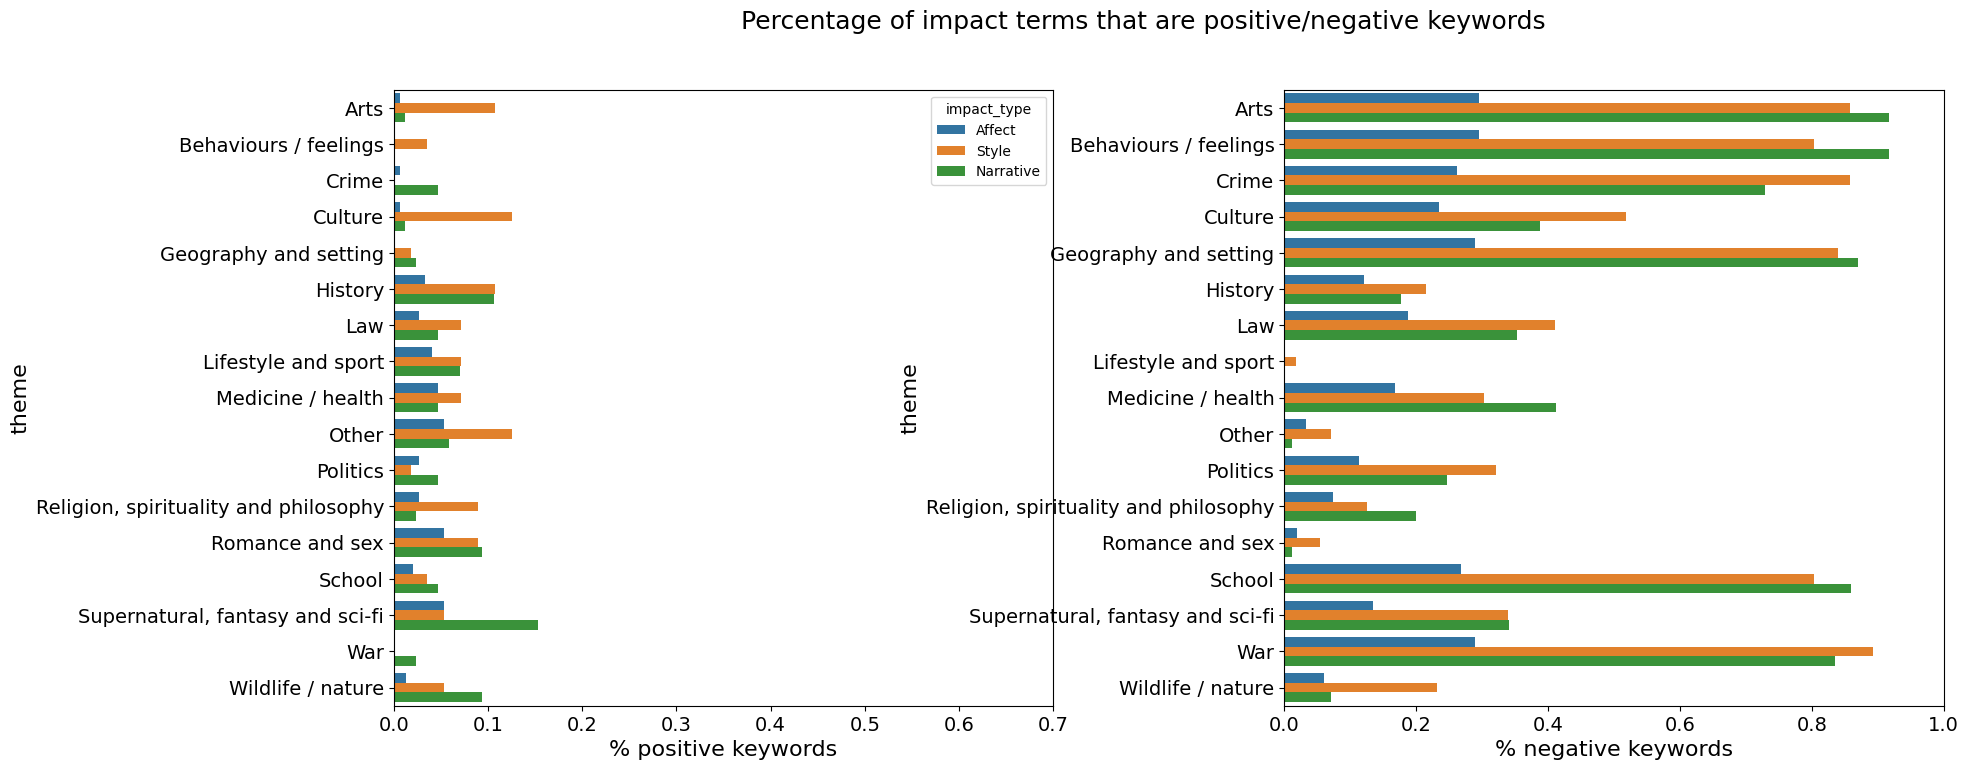

In [324]:
sdf
impact_type = 'Affect'
df_list = []
for impact_type in impact_types:
    impact_terms_frac = num_terms_theme.loc[impact_type] / num_impact_terms[impact_type]
    impact_terms_frac['impact_type'] = impact_type
    df_list.append(impact_terms_frac)

impact_terms_frac = pd.concat(df_list)
impact_terms_frac

fig, ax = plt.subplots(1, 2)
sns.barplot(data=impact_terms_frac.reset_index(), y='theme', x='positive %Diff', hue='impact_type', ax=ax[0])
sns.barplot(data=impact_terms_frac.reset_index(), y='theme', x='negative %Diff', hue='impact_type', ax=ax[1])
ax[0].set_xlabel('% positive keywords', fontsize=16)
ax[1].set_xlabel('% negative keywords', fontsize=16)
ax[0].set_ylabel('theme', fontsize=16)
ax[1].set_ylabel('theme', fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_xlim(0, 0.7)
ax[1].set_xlim(0, 1.0)
fig.suptitle('Percentage of impact terms that are positive/negative keywords', fontsize=18)
ax[1].get_legend().remove()
#ax[1].legend(bbox_to_anchor=(1, 1))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=None)

#fig.tight_layout()
fig.set_size_inches(20, 8)
fig.savefig('../images/num_key_terms_per_theme.png', dpi=150)

In [325]:
import dataframe_image as dfi

In [326]:
(percent_diff[percent_diff.impact_type == 'Style']
 #.rename(columns=theme_map_short)
 #.drop(['Non-fic', 'Oth. fic'], axis=1)
 .drop('impact_type', axis=1)
 .corr()
 .style.format(precision=2)
 .background_gradient(axis=None))

,Arts,Behaviours / feelings,Crime,Culture,Geography and setting,History,Law,Lifestyle and sport,Medicine / health,Other,Politics,"Religion, spirituality and philosophy",Romance and sex,School,"Supernatural, fantasy and sci-fi",War,Wildlife / nature
Arts,1.00,-0.67,-0.02,-0.04,0.51,0.10,0.40,-0.23,-0.32,-0.11,-0.10,0.16,-0.27,-0.67,-0.50,0.06,0.07
Behaviours / feelings,-0.67,1.00,-0.43,-0.00,-0.35,-0.38,-0.43,0.46,0.45,-0.03,-0.05,-0.02,0.28,0.96,0.39,-0.46,0.00
Crime,-0.02,-0.43,1.00,0.31,0.27,0.51,0.45,-0.30,-0.24,0.18,0.22,-0.01,-0.08,-0.38,0.02,0.92,0.09
Culture,-0.04,-0.00,0.31,1.00,-0.10,0.03,0.10,0.08,0.04,0.07,0.05,0.48,0.22,-0.02,0.14,0.07,0.60
Geography and setting,0.51,-0.35,0.27,-0.10,1.00,0.41,0.52,-0.19,-0.30,0.01,0.08,-0.30,-0.18,-0.32,-0.29,0.42,-0.32
History,0.10,-0.38,0.51,0.03,0.41,1.00,0.28,-0.11,-0.27,0.22,0.19,-0.18,-0.23,-0.34,-0.17,0.54,0.02
Law,0.40,-0.43,0.45,0.10,0.52,0.28,1.00,-0.27,-0.24,-0.06,0.13,-0.21,-0.04,-0.41,-0.26,0.40,-0.06
Lifestyle and sport,-0.23,0.46,-0.30,0.08,-0.19,-0.11,-0.27,1.00,0.14,0.04,-0.07,-0.06,0.17,0.44,0.11,-0.30,0.02
Medicine / health,-0.32,0.45,-0.24,0.04,-0.30,-0.27,-0.24,0.14,1.00,-0.02,0.36,0.34,0.13,0.21,0.16,-0.28,0.10
Other,-0.11,-0.03,0.18,0.07,0.01,0.22,-0.06,0.04,-0.02,1.00,-0.04,-0.15,-0.16,-0.01,0.26,0.15,-0.12


In [327]:
dfi.export(percent_diff[percent_diff.impact_type == 'Affect']
 #.rename(columns=theme_map_short)
 #.drop(['Non-fic', 'Oth. fic'], axis=1)
 .drop('impact_type', axis=1)
 .corr()
 .style.format(precision=2)
 .background_gradient(axis=None), '../images/percent_diff_corr/percent_diff_corr-theme-affect.png', dpi=150)

In [328]:
dfi.export(percent_diff[percent_diff.impact_type == 'Narrative']
 #.rename(columns=theme_map_short)
 #.drop('impact_type', axis=1)
 .corr()
 .style.format(precision=2)
 .background_gradient(axis=None), '../images/percent_diff_corr/percent_diff_corr-theme-narrative.png', dpi=150)

/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_73139/962286834.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  .corr()


In [329]:
dfi.export(percent_diff[percent_diff.impact_type == 'Style']
 #.rename(columns=theme_map_short)
 #.drop('impact_type', axis=1)
 .corr()
 .style.format(precision=2)
 .background_gradient(axis=None), '../images/percent_diff_corr/percent_diff_corr-theme-style.png', dpi=150)

/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_73139/2241219179.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  .corr()


In [279]:
percent_diff

,Arts,Behaviours / feelings,Crime,Culture,Geography and setting,History,Law,Lifestyle and sport,Medicine / health,Other,Politics,"Religion, spirituality and philosophy",Romance and sex,School,"Supernatural, fantasy and sci-fi",War,Wildlife / nature
impact_term,,,,,,,,,,,,,,,,,
(ik|je) (hoopte|hoopt),-65.132259,-23.915935,-53.329540,-43.641432,-51.018449,-24.154968,8.438420,-100.000000,-59.255837,-100.000000,-100.000000,-64.889795,76.489117,-16.547646,-89.799669,-52.380557,-100.000000
(ik|je|lezer) (voelt|voelde),-50.604230,-35.454295,-52.845908,-59.772976,-42.147451,-58.361216,-32.448643,-76.230333,-47.023822,-10.730026,-94.545323,-68.386446,-60.376557,-30.490641,-61.531938,-50.719807,-78.291937
(in).+(één|een|1).+(adem|avond|dag|keer|middag|ruk|stuk|zucht).+(gelezen|uitgelezen|uit),-57.410536,-35.262053,-43.745866,-49.701169,-56.857322,-65.281875,-23.992868,-31.085177,-37.113670,3.496237,-51.051777,-66.916452,156.295530,-31.705306,-59.858244,-46.924658,-39.598847
(laat|liet|lieten).+(mij|me|je|lezer).+(niet).+(los),-50.316346,-45.329483,-35.449611,-60.463712,-51.669705,-13.564604,-42.811023,-100.000000,-95.092263,16.153940,-91.128897,-31.340044,-100.000000,-37.251824,-80.052686,-32.149020,-64.683466
(neem*|nam).+(je|me|lezer|ons).+(mee),-32.479591,-47.735708,-52.076642,-48.418872,-34.189607,11.503896,-30.026868,-100.000000,-5.818542,-100.000000,-49.816428,-22.602755,-100.000000,-52.313158,-77.514300,-51.417256,-80.119014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
verrassing,-64.330116,-48.519008,-15.058051,-23.994511,-55.412991,-79.040304,0.363097,-67.043944,-82.130874,-100.000000,-50.631554,-92.704718,-100.000000,-40.783268,-16.137562,-31.262912,-1.817356
verrast,inf,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000
verslavend,-53.796518,-40.041717,-31.901822,-35.658043,-72.558187,-2.662582,-50.015581,-100.000000,-54.235058,-100.000000,-76.674582,-100.000000,935.668319,-35.672609,-20.610631,-46.366032,-100.000000


In [278]:
(percent_diff[percent_diff.impact_type == 'affect']
 .rename(columns=theme_map_short)
 .drop('impact_type', axis=1)
 .corr()
 .style.format(precision=2)
 .background_gradient(axis=None))

AttributeError: 'DataFrame' object has no attribute 'impact_type'

In [323]:
(percent_diff[percent_diff.impact_type == 'narrative']
 .rename(columns=theme_map_short)
 .drop('impact_type', axis=1)
 .corr()
 .style.format(precision=2)
 .background_gradient(axis=None))

,Child. fic,Fantasy,Hist. fic,Lit. fic,Lit. thriller,Non-fic,Oth. fic,Region. fic,Romance,Suspense,YA
Child. fic,1.00,0.60,-0.12,-0.41,-0.06,0.09,-0.13,0.02,0.07,0.07,0.46
Fantasy,0.60,1.00,-0.02,-0.41,0.09,-0.29,-0.15,-0.10,0.13,0.24,0.48
Hist. fic,-0.12,-0.02,1.00,0.05,-0.01,-0.15,-0.18,0.50,0.46,-0.33,0.24
Lit. fic,-0.41,-0.41,0.05,1.00,-0.44,-0.04,-0.18,0.01,-0.07,-0.35,-0.32
Lit. thriller,-0.06,0.09,-0.01,-0.44,1.00,-0.38,-0.25,-0.12,-0.14,0.32,0.12
Non-fic,0.09,-0.29,-0.15,-0.04,-0.38,1.00,-0.08,0.02,-0.06,-0.30,-0.22
Oth. fic,-0.13,-0.15,-0.18,-0.18,-0.25,-0.08,1.00,-0.14,-0.10,-0.00,-0.23
Region. fic,0.02,-0.10,0.50,0.01,-0.12,0.02,-0.14,1.00,0.48,-0.30,0.20
Romance,0.07,0.13,0.46,-0.07,-0.14,-0.06,-0.10,0.48,1.00,-0.25,0.44
Suspense,0.07,0.24,-0.33,-0.35,0.32,-0.30,-0.00,-0.30,-0.25,1.00,-0.26


In [324]:
(percent_diff[percent_diff.impact_type == 'style']
 .rename(columns=genre_map_short)
 .drop('impact_type', axis=1)
 .corr()
 .style.format(precision=2)
 .background_gradient(axis=None))

,Child. fic,Fantasy,Hist. fic,Lit. fic,Lit. thriller,Non-fic,Oth. fic,Region. fic,Romance,Suspense,YA
Child. fic,1.00,0.16,-0.05,-0.25,-0.30,0.08,-0.07,0.13,0.43,-0.36,0.60
Fantasy,0.16,1.00,0.03,-0.43,0.49,-0.24,-0.46,0.06,0.02,0.19,0.43
Hist. fic,-0.05,0.03,1.00,-0.21,0.24,-0.06,-0.34,0.54,-0.08,0.10,0.15
Lit. fic,-0.25,-0.43,-0.21,1.00,-0.44,-0.36,0.34,-0.34,-0.18,-0.44,-0.49
Lit. thriller,-0.30,0.49,0.24,-0.44,1.00,-0.31,-0.65,0.16,-0.23,0.57,0.13
Non-fic,0.08,-0.24,-0.06,-0.36,-0.31,1.00,0.17,-0.03,-0.04,-0.25,-0.12
Oth. fic,-0.07,-0.46,-0.34,0.34,-0.65,0.17,1.00,-0.10,0.24,-0.35,-0.31
Region. fic,0.13,0.06,0.54,-0.34,0.16,-0.03,-0.10,1.00,0.39,0.05,0.33
Romance,0.43,0.02,-0.08,-0.18,-0.23,-0.04,0.24,0.39,1.00,-0.23,0.47
Suspense,-0.36,0.19,0.10,-0.44,0.57,-0.25,-0.35,0.05,-0.23,1.00,-0.01


In [325]:
impact_keyness = keyness[keyness.impact_type == impact_type]
key_impact_terms = impact_keyness[genre][impact_keyness[genre] > LL_threshold].index
selected_diff[genre] = percent_diff[genre].loc[key_impact_terms].rename('%Diff')
selected_diff[genre]
# selected_freq[genre] = key_cat_freq[impact_type][genre].loc[key_impact_terms].rename('Freq')
key_cat_freq[impact_type][genre].loc[key_impact_terms].rename('Freq')

impact_term
(ik|je|lezer) (voelt|voelde)                            281.0
(laat|liet|lieten).+(mij|me|je|lezer).+(niet).+(los)     52.0
(neem*|nam).+(je|me|lezer|ons).+(mee)                    78.0
(spreekt|spreken|sprak|spraken).+(me).+(aan)             25.0
aangrijpend                                             144.0
                                                        ...  
verrassend                                               42.0
verrassing                                              197.0
verslavend                                               67.0
voelbaar                                                 90.0
wegleggen                                               358.0
Name: Freq, Length: 66, dtype: float64

In [326]:
#pd.concat([selected_diff[genre], selected_freq[genre]], axis=1)
selected_diff[genre]
selected_freq[genre]
percent_diff

,Children_fiction,Fantasy_fiction,Historical_fiction,Literary_fiction,Literary_thriller,Non-fiction,Other fiction,Regional_fiction,Romanticism,Suspense,Young_adult,impact_type
impact_term,,,,,,,,,,,,
(ik|je) (hoopte|hoopt),-20.830257,9.384253,-20.382465,4.250983,10.289053,-57.068957,-1.002426,4.371689,35.705505,23.790070,29.329169,affect
(ik|je|lezer) (voelt|voelde),-33.962762,-12.516081,70.682416,21.542107,-4.404224,-38.721403,11.054431,77.291690,31.358105,-5.770600,17.744871,affect
(in).+(één|een|1).+(adem|avond|dag|keer|middag|ruk|stuk|zucht).+(gelezen|uitgelezen|uit),-8.019373,-9.743079,-5.638407,1.442358,11.420705,-17.728074,19.505286,45.099209,9.970009,-1.268517,-6.778628,affect
(laat|liet|lieten).+(mij|me|je|lezer).+(niet).+(los),-61.634369,30.345672,45.898044,28.094150,18.851936,-71.117947,-11.498473,37.215927,-60.042108,34.050948,-6.922882,affect
(neem*|nam).+(je|me|lezer|ons).+(mee),-33.702724,10.389076,92.751713,14.106953,-26.754821,13.301931,34.214665,21.122701,16.204767,-5.076271,-26.708880,affect
...,...,...,...,...,...,...,...,...,...,...,...,...
verrassing,-27.063578,1.939195,-27.744599,-27.834656,28.174456,5.811262,-15.280087,-31.217622,14.171924,34.554732,-14.030648,narrative
verrast,-100.000000,-100.000000,-100.000000,-13.361745,-35.587306,148.638096,-100.000000,-100.000000,-100.000000,227.423082,-100.000000,narrative
verslavend,44.726271,139.583738,-24.442647,2.548867,-9.419649,-44.244791,-29.703677,-13.673456,26.147828,-34.490940,72.769325,narrative


In [342]:
selected_diff_freq = pd.DataFrame()
df_list = []

for impact_type in impact_types:
    selected_diff = {}
    selected_freq = {}
    impact_selected_diff_freq = {}
    genre_df_list = []
    impact_keyness = keyness[keyness.impact_type == impact_type]
    impact_percent_diff = percent_diff[percent_diff.impact_type == impact_type]
    for genre in genres:
        key_impact_terms = impact_keyness[genre][impact_keyness[genre] > LL_threshold].index
        
        selected_diff[genre] = impact_percent_diff[genre].loc[key_impact_terms].rename('%Diff')
        
        selected_freq[genre] = key_cat_freq[impact_type][genre].loc[key_impact_terms].rename('Freq')
        genre_selected_diff_freq = pd.concat([selected_diff[genre], selected_freq[genre]], axis=1).reset_index()
        
        # add column with genre label
        genre_selected_diff_freq['genre'] = genre
        genre_df_list.append(genre_selected_diff_freq)
    impact_selected_diff_freq = pd.concat(genre_df_list)
    impact_selected_diff_freq['impact_type'] = impact_type
    df_list.append(impact_selected_diff_freq)

significant_diff_freq = pd.concat(df_list)
        
significant_diff_freq

,impact_term,%Diff,Freq,genre,impact_type
0,(ik|je|lezer) (voelt|voelde),-33.962762,281.0,Children_fiction,affect
1,(in).+(één|een|1).+(adem|avond|dag|keer|middag...,-8.019373,994.0,Children_fiction,affect
2,(laat|liet|lieten).+(mij|me|je|lezer).+(niet)....,-61.634369,52.0,Children_fiction,affect
3,(neem*|nam).+(je|me|lezer|ons).+(mee),-33.702724,78.0,Children_fiction,affect
4,(raakt|raken|raakte|raakten).+(me|mij|je|lezer),-44.614707,162.0,Children_fiction,affect
...,...,...,...,...,...
57,verrassend,-55.615765,85.0,Young_adult,narrative
58,verrassing,-14.030648,390.0,Young_adult,narrative
59,verslavend,72.769325,130.0,Young_adult,narrative
60,voelbaar,-29.875980,238.0,Young_adult,narrative


In [343]:
significant_diff_freq[significant_diff_freq.genre == genre].sort_values('%Diff')

,impact_term,%Diff,Freq,genre,impact_type
17,intrigerend,-100.000000,0.0,Young_adult,style
44,schokkend,-100.000000,0.0,Young_adult,narrative
63,literair,-82.051853,127.0,Young_adult,affect
73,onderhoudend,-81.227294,4.0,Young_adult,affect
30,fraai,-79.369653,62.0,Young_adult,affect
...,...,...,...,...,...
53,inleven,98.152768,753.0,Young_adult,affect
7,benieuwd,116.255482,1200.0,Young_adult,narrative
12,benieuwd,136.680831,1200.0,Young_adult,affect
38,ontzettend,138.122144,159.0,Young_adult,narrative


In [344]:
temp = significant_diff_freq.groupby(['genre', 'impact_type'])[['Freq', '%Diff']].corr()
temp.loc[:,:,'Freq']['%Diff'].unstack()

impact_type,affect,narrative,style
genre,,,
Children_fiction,0.424819,0.266712,0.279256
Fantasy_fiction,0.191101,0.195035,0.073921
Historical_fiction,0.195047,0.015715,0.288902
Literary_fiction,-0.043542,-0.126917,-0.059191
Literary_thriller,0.445608,0.580961,-0.046915
Non-fiction,0.322805,0.438597,0.304205
Other fiction,-0.072062,-0.155935,-0.098348
Regional_fiction,-0.000216,0.246314,0.291615
Romanticism,0.353674,0.619626,0.421308


In [345]:
significant_diff_freq.shape, significant_diff_freq.replace([np.inf, -np.inf], np.nan).dropna().shape
significant_diff_freq['sign'] = significant_diff_freq['%Diff'].apply(lambda x: 'positive %Diff' if x > 0 else 'negative %Diff')

In [349]:
significant_diff_freq.groupby(['genre', 'impact_type'])
df_list = []

for impact_type in impact_types:
    for genre in genres:
        sdf = significant_diff_freq[(significant_diff_freq.impact_type == impact_type) & (significant_diff_freq.genre == genre)]
        top_sdf = pd.concat([
            sdf.sort_values('%Diff').tail(10), 
            sdf.sort_values('%Diff').head(10)
        ])
        df_list.append(top_sdf)

top_sdf = pd.concat(df_list)

In [352]:
sdf = significant_diff_freq
sdf.shape, top_sdf.shape

((2030, 6), (660, 6))

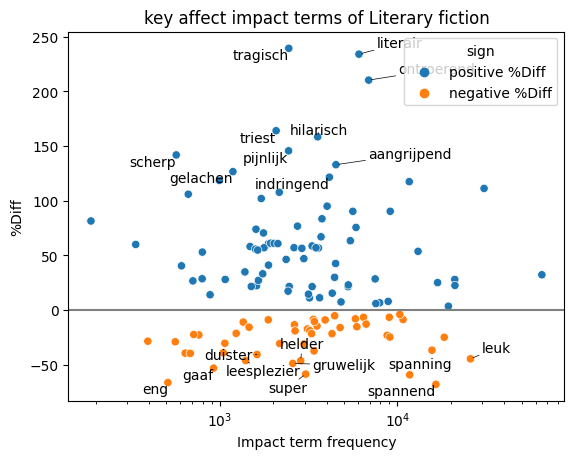

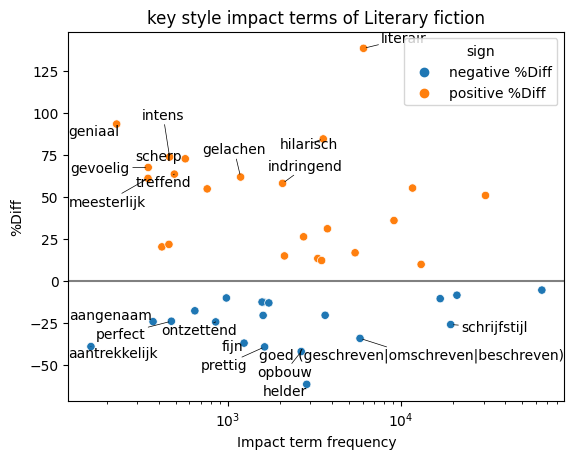

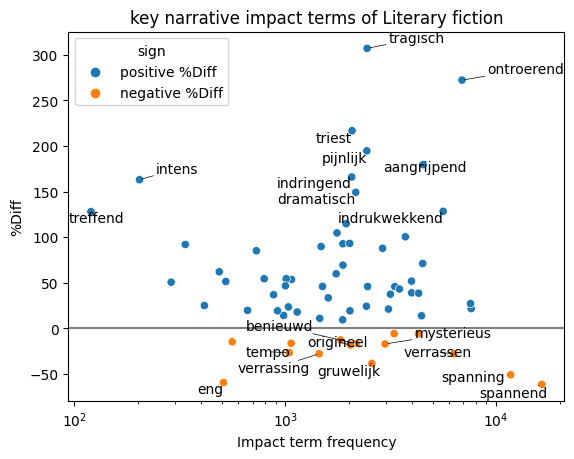

In [356]:
import matplotlib.pyplot as plt
from adjustText import adjust_text


def plot_freq_diff(sdf, impact_type, genre, topn=10):
    sdf = sdf[(sdf.impact_type == impact_type) & (sdf.genre == genre)]
    top_sdf = pd.concat([
        sdf.sort_values('%Diff').tail(topn), 
        sdf.sort_values('%Diff').head(topn)
    ])
    ax = sns.scatterplot(data=sdf, x='Freq', y='%Diff', hue='sign')
    ax.set_xscale('log')
    
    plt.axhline(y=0.0, color='gray', linestyle='-')
    
    x = list(top_sdf['Freq'])
    y = list(top_sdf['%Diff'])
    labels = list(top_sdf['impact_term'])
    
    ax.set_xlabel('Impact term frequency')
    ax.set_title(f'key {impact_type} impact terms of {genre_map_print[genre]}')
    
    texts = [plt.text(x[i], y[i], labels[i]) for i in range(len(x))]
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
    
    ax.figure.savefig(f'../images/percent_diff/percent_diff_{genre}.png', dpi=150)
    plt.show()


genre = 'Literary_fiction'
impact_type = 'affect'

for impact_type in impact_types:
    plot_freq_diff(sdf, impact_type, genre, topn=10)


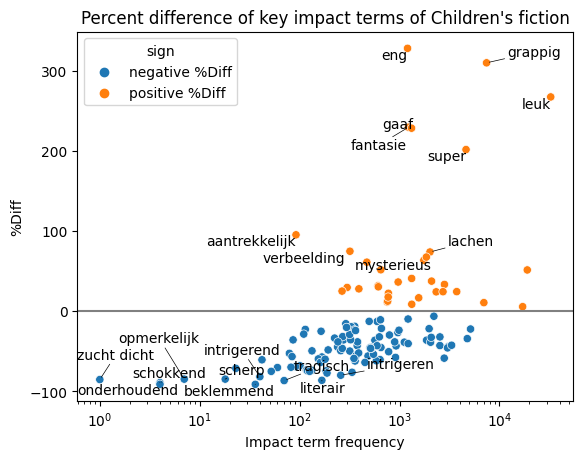

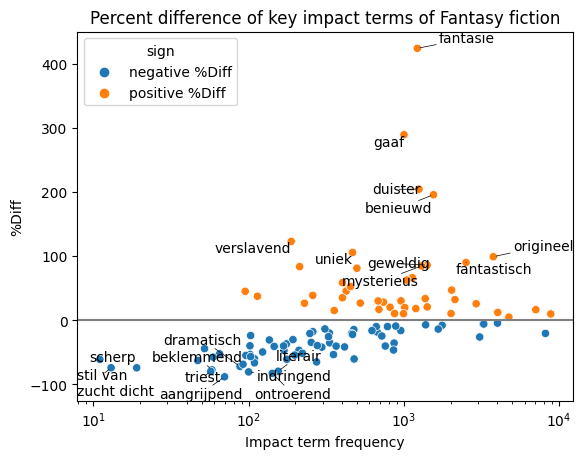

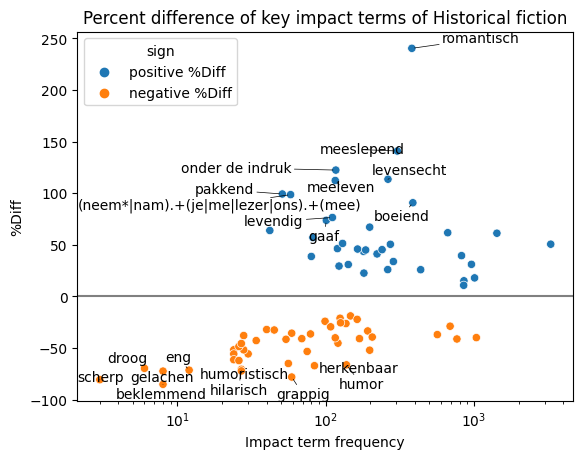

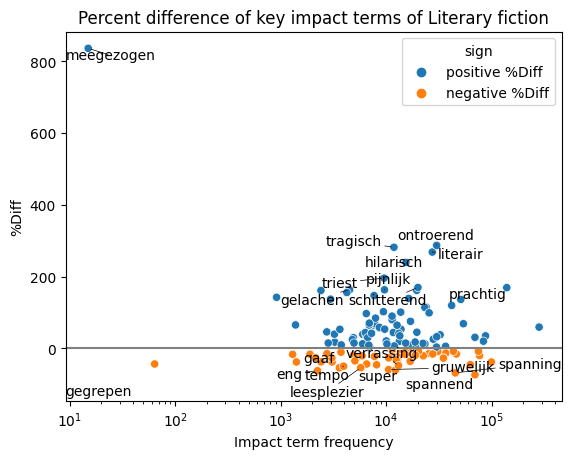

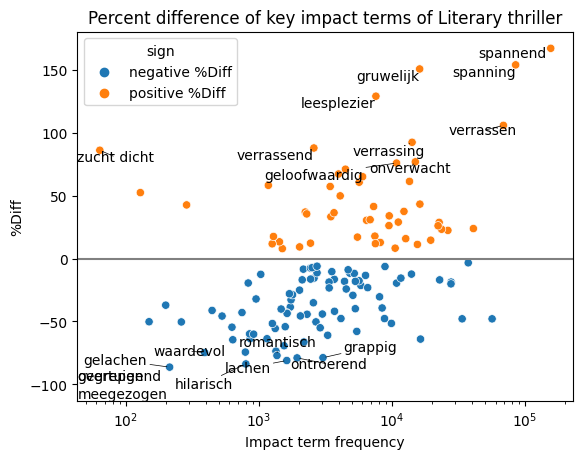

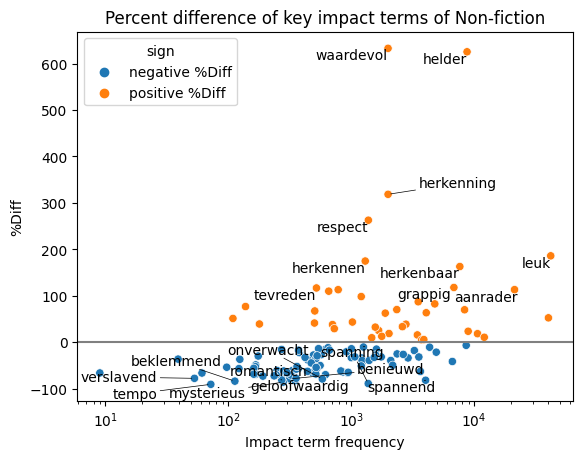

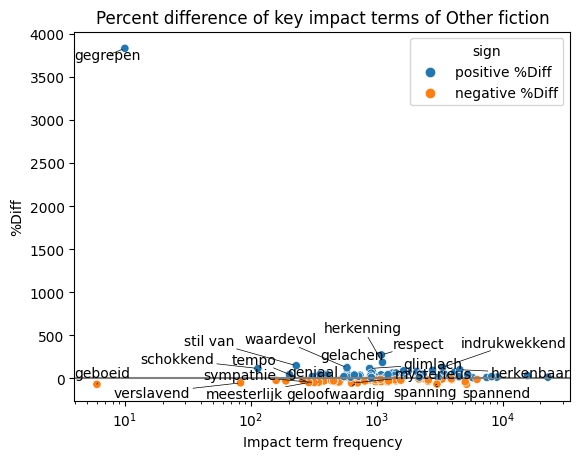

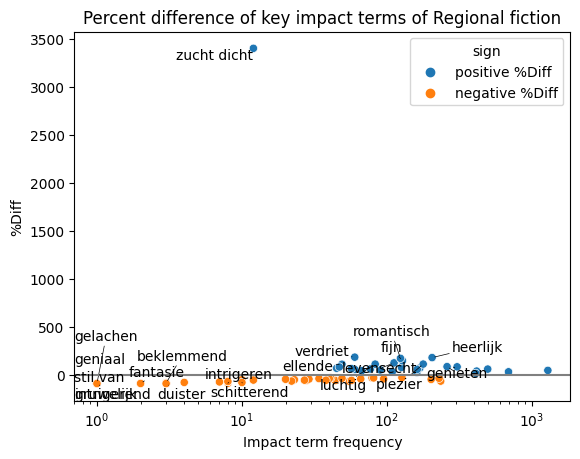

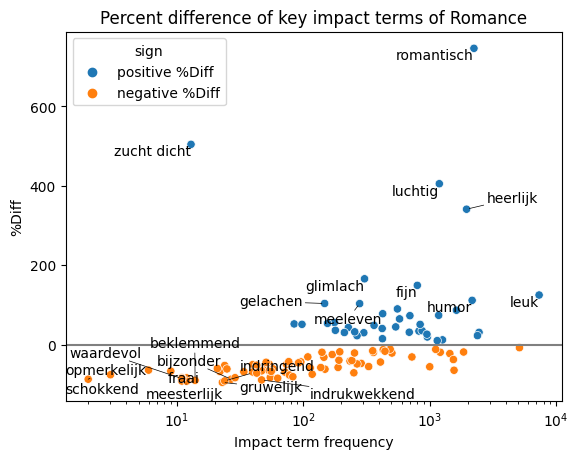

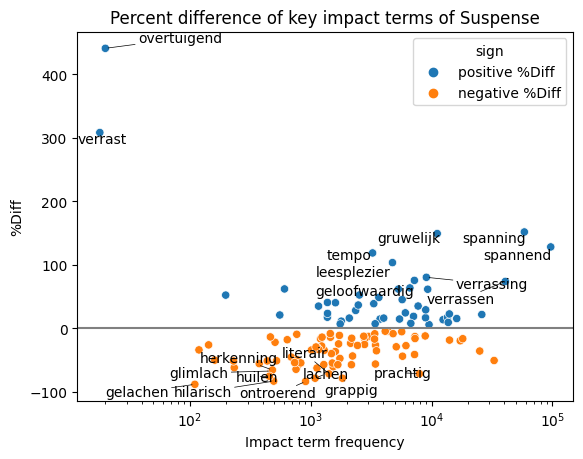

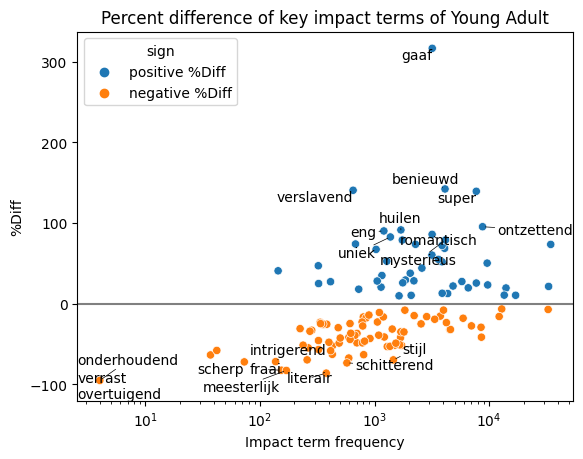

In [229]:
genre = 'Children_fiction'

for genre in genres:
    plot_freq_diff(selected_diff_freq, genre, topn=10)

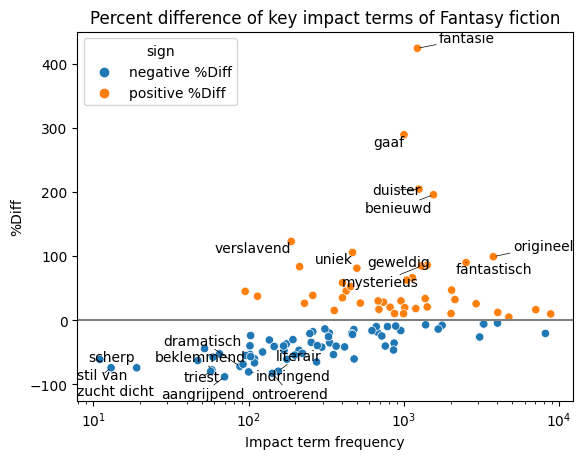

In [221]:
genre = 'Fantasy_fiction'

plot_freq_diff(selected_diff_freq, genre, topn=10)

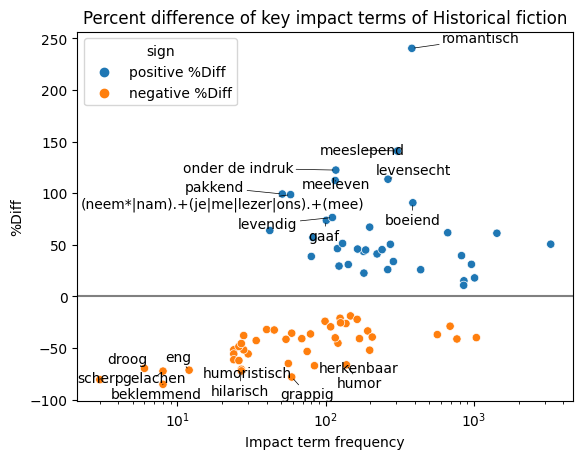

In [222]:
genre = 'Historical_fiction'

plot_freq_diff(selected_diff_freq, genre, topn=10)

We're ready to add in this info with the rest of the dataframe. We select however the most useful columns to make the dataframe tidy.

In [22]:
prevalence_keyness = pd.merge(keyness, prevalence[['impact_term', 'nur_genre', 'prevalent_impact']], on=['impact_term', 'nur_genre'], how='left')

In [23]:
# again, remove duplicates, if any
prevalence_keyness_copy = prevalence_keyness.drop_duplicates()

In [24]:
# there were indeed duplicates:
prevalence_keyness_copy.shape, prevalence_keyness.shape

((2274, 6), (7635611, 6))

This is our final dataframe:

In [25]:
prevalence_keyness_copy.head()

,nur_genre,impact_term,NF_W,NF_WC,Keyness,prevalent_impact
0,Children_fiction,(begrijp|begrijpt|begreep|begrepen|begrijpen)....,0.002271,0.003228,-0.351958,reflection
449,Children_fiction,(boek|verhaal|verhalen|portret*|wijze|verslag|...,0.000135,0.000176,-0.268096,reflection
475,Children_fiction,(dit|dat|het),0.000451,0.000916,-0.708456,reflection
562,Children_fiction,(geeft|geven|gegeven|biedt|bieden|geboden|verg...,0.000415,0.001625,-1.365660,reflection
647,Children_fiction,(geschreven|omschreven|beschreven),0.006153,0.009402,-0.423902,affect/style


This dataframe is used later on for producing figures. These figures are rendered in R because the graphical capabilities of this software allows more flexibility for producing plots.

The code to reproduce the scatter plots in R present in the paper is `plot_keyness.R`. It takes as input `prevalence_keyness.csv` and it saves automatically the plots.

In [26]:
prevalence_keyness_copy.to_csv('prevalence_keyness.csv', index = False)